<a href="https://colab.research.google.com/github/alibakh62/DeepFake-Kaggle/blob/master/notebook/colab/DeepFakeDetection_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version 1

Main steps:



*   Videos -> frames (independent images)
*   Pre-trained convnets -> training only the top layer
*   Prediction on video -> Rolling moving average



# Config and Imports

In [0]:
# from google.colab import drive
# drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [1]:
!pip install ipython-autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=90112a73ff70dbefec54e32c5547c1dbfc7d37f4ecd225d6b2e8d623a59f7623
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
%load_ext autotime
%tensorflow_version 2.x
%matplotlib inline 

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.utils import get_file

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
import os
import shutil
from glob import glob
import math
import h5py
import matplotlib
import matplotlib.pyplot as plt
import random
#import cv2
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from skimage import io, transform
from sklearn.metrics import accuracy_score
from scipy import misc
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import cv2 as cv

time: 8.1 s


# Models

### Importing pretrained convnets

In [4]:
from tensorflow.keras.applications import Xception

conv_base = Xception(include_top=False)
# conv_base.summary()

83689472/83683744 [==============================] - 1s 0us/step
time: 3.63 s


In [5]:
# freezing pretrained model
conv_base.trainable = False

# adding top layers
model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation="selu"))
model.add(Dense(265, activation="selu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 265)               271625    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 266       
Total params: 23,231,547
Trainable params: 2,370,067
Non-trainable params: 20,861,480
_________________________________________________________________
time: 1.08 s


# DataPrep

### Config
***

In [6]:
# configs
MODELS_FOLDER = '/content/drive/My Drive/DeepFake/models'
BASE_FOLDER = '/content/drive/My Drive/DeepFake'
TRAIN_SAMPLE_VIDEOS = 'train_sample_videos'
TEST_VIDEOS = 'test_videos'
TRAIN_FRAMES_FOLDER = 'train_frames'
VALID_FRAMES_FOLDER = 'valid_frames'
TEST_FRAMES_FOLDER = 'test_frames'
DATA_FOLDER = 'data'
TRAIN_FOLDER = 'train'
VALID_FOLDER = 'valid'
TEST_FOLDER = 'test'
INPUT_SHAPE = (224, 224)
BATCH_SIZE = 32

time: 3.18 ms


### Meta data
***

In [7]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(BASE_FOLDER, path, json_file))
    df = df.T
    return df

train_list = list(os.listdir(os.path.join(BASE_FOLDER, TRAIN_SAMPLE_VIDEOS)))
test_list = list(os.listdir(os.path.join(BASE_FOLDER, TEST_VIDEOS)))
json_file = [file for file in train_list if  file.endswith('json')][0]
meta_train_df = get_meta_from_json(TRAIN_SAMPLE_VIDEOS)
meta_train_df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


time: 11.1 s


### Converting videos into images
***

In [0]:
#@title Sample or All
sample = False #@param {type:"boolean"}
no_of_samples = 5 #@param {type:"integer"}

def get_frames(cap, name, dirname, resize=None):
    frameRate = cap.get(5) #frame rate
    count = 0
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a different folder
            if resize is not None:
                # image = np.array(tf.image.resize(frame, resize))
                image = cv.resize(frame, resize)
            else:
                image = frame
            if not os.path.isdir(os.path.join(BASE_FOLDER, dirname)):
                os.mkdir(os.path.join(BASE_FOLDER, dirname))
            count += 1
            fn = os.path.splitext(name)[0] + f"_frame{count}.jpg"
            file_path = os.path.join(BASE_FOLDER, dirname, fn)
            cv.imwrite(file_path, image)
    cap.release()

cnt_max = 2e10
if sample:
    cnt_max = no_of_samples

def walkdir(dirpath):
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            if name != 'metadata.json':
                yield os.path.abspath(os.path.join(dirpath, name)), name

filescount = meta_train_df.index.nunique()

cnt = 1
X_train_full, y_train_full = [], []
for path, name in tqdm_notebook(walkdir(os.path.join(BASE_FOLDER, TRAIN_SAMPLE_VIDEOS)), total=filescount):
    if cnt <= cnt_max:
        cap = cv.VideoCapture(path)
        get_frames(cap, name, TRAIN_FRAMES_FOLDER)
        cnt += 1


time: 42min 54s


#### Getting train data & label
***

In [0]:
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d

images = glob(os.path.join(BASE_FOLDER, f"{TRAIN_FRAMES_FOLDER}/*.jpg"))
X_full, y_full = [], []
for i in tqdm_notebook(images):
    frame_name = i.split('/')[-1]
    image_name = frame_name.split("_")[0]
    label = 1
    if meta_train_df.loc[meta_train_df.index == image_name+'.mp4', "label"].values[0] == 'REAL':
        label = 0
    # reading frames
    img = image.load_img(i, target_size=(512, 512, 3))
    img = image.img_to_array(img)
    img = img/255
    X_full.append(img)
    y_full.append(label)

X = np.array(X_full)
y = column_or_1d(y_full)
print(X.shape)
print(y.shape)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")

### Converting videos to images (Keras)
***

#### Creating directories

In [0]:
# base folder
if not os.path.isdir(BASE_FOLDER):
    os.mkdir(BASE_FOLDER)

# data folder
data_dir = os.path.join(BASE_FOLDER, DATA_FOLDER)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# train folder
train_dir = os.path.join(data_dir, TRAIN_FOLDER)
if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

if not os.path.isdir(os.path.join(train_dir, 'REAL')):
    os.mkdir(os.path.join(train_dir, 'REAL'))

if not os.path.isdir(os.path.join(train_dir, 'FAKE')):
    os.mkdir(os.path.join(train_dir, 'FAKE'))

# valid folder
valid_dir = os.path.join(data_dir, VALID_FOLDER)
if not os.path.isdir(valid_dir):
    os.mkdir(valid_dir)

if not os.path.isdir(os.path.join(valid_dir, 'REAL')):
    os.mkdir(os.path.join(valid_dir, 'REAL'))

if not os.path.isdir(os.path.join(valid_dir, 'FAKE')):
    os.mkdir(os.path.join(valid_dir, 'FAKE'))

# test folder
test_dir = os.path.join(data_dir, TEST_FOLDER)
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)



time: 28.6 ms


#### Adding frames to train & validation folders

In [0]:
#@title Sample or All
sample = False #@param {type:"boolean"}
no_of_samples = 2 #@param {type:"integer"}

time: 1.2 ms


In [0]:
#@title Train/Validation Split
train_val_split = 0.7 #@param {type: "number"}

time: 1.2 ms


In [18]:
#TODO: resize not necessary here, will be done in ImageDataGenerator
def get_frames(cap, name, dirname, resize=None, test=False):
    frameRate = cap.get(5) #frame rate
    if not test:
        label = meta_train_df.loc[meta_train_df.index == name, "label"].values[0]
    count = 0
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a different folder
            if resize is not None:
                # image = np.array(tf.image.resize(frame, resize))
                image = cv.resize(frame, resize)
            else:
                image = frame
            count += 1
            fn = os.path.splitext(name)[0] + f"_frame{count}.jpg"
            if test:
                file_path = os.path.join(BASE_FOLDER, dirname, fn)
            else:
                file_path = os.path.join(BASE_FOLDER, dirname, label, fn)
            cv.imwrite(file_path, image)
    cap.release()

def walkdir(dirpath):
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            if name != 'metadata.json':
                yield os.path.abspath(os.path.join(dirpath, name)), name

time: 17.7 ms


In [0]:
cnt_max = 2e10
if sample:
    cnt_max = no_of_samples

filescount = meta_train_df.index.nunique()
traincount = int(filescount * train_val_split)

cnt = 1
for path, name in tqdm_notebook(walkdir(os.path.join(BASE_FOLDER, TRAIN_SAMPLE_VIDEOS)), total=filescount):
    if cnt <= cnt_max:
        cap = cv.VideoCapture(path)
        if cnt <= traincount:
            dirname = os.path.join(DATA_FOLDER, TRAIN_FOLDER)
        else:
            dirname = os.path.join(DATA_FOLDER, VALID_FOLDER)
        get_frames(cap, name, dirname)
        cnt += 1

time: 37min


In [0]:
print(f"Total REAL train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FOLDER, 'REAL')))}")
print(f"Total FAKE train: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FOLDER, 'FAKE')))}")
print(f"Total REAL valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FOLDER, 'REAL')))}")
print(f"Total FAKE valid: {len(os.listdir(os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FOLDER, 'FAKE')))}")

Total REAL train: 550
Total FAKE train: 2530
Total REAL valid: 297
Total FAKE valid: 1023
time: 41.8 s


### Image generator for Keras

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, TRAIN_FOLDER)
valid_dir = os.path.join(BASE_FOLDER, DATA_FOLDER, VALID_FOLDER)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 3080 images belonging to 2 classes.
Found 1320 images belonging to 2 classes.
time: 49.7 s


In [77]:
# for data_batch, label_batch in train_generator:
#     print(f"data batch shape: {data_batch.shape}")
#     print(f"label batch shape: {label_batch.shape}")
#     break

data batch shape: (32, 224, 224, 3)
label batch shape: (32,)
time: 24.7 s


# Training

### Fitting: default

In [0]:
# checkpoints
CHECKPOINT = 'xception_v1.hDF5'
weights_path = os.path.join(MODELS_FOLDER, CHECKPOINT)
from keras.callbacks import ModelCheckpoint
ckp = ModelCheckpoint(weights_path, save_best_only=True, monitor='val_loss', mode='min')

time: 128 ms


Using TensorFlow backend.


In [0]:
# compiling the model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

time: 71.3 ms


In [0]:
# training the model
model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), callbacks=[ckp], batch_size=16)

### Fitting: with generators

In [9]:
from datetime import datetime
timestamp = datetime.now().strftime(format="%Y%m%d_%H%M%S")
CHECKPOINT = f"xception_v1_{timestamp}.h5"
weights_path = os.path.join(MODELS_FOLDER, CHECKPOINT)

from keras.callbacks import ModelCheckpoint
ckp = ModelCheckpoint(weights_path, save_best_only=True, monitor='val_loss', mode='min')

# compiling the model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

time: 154 ms


Using TensorFlow backend.


In [0]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples//BATCH_SIZE,
    callbacks=[ckp])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 96 steps, validate for 41 steps
Epoch 1/10
20/96 [=====>........................] - ETA: 34:03 - loss: 1.3548 - accuracy: 0.7305

In [0]:
model.save(weights_path)

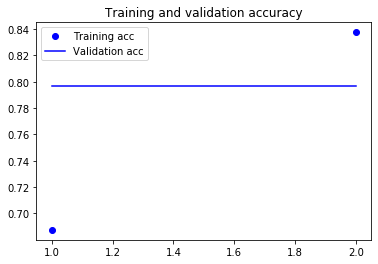

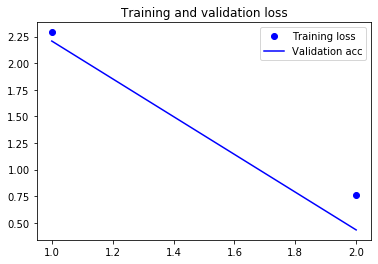

time: 350 ms


In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Prediction

### Converting test videos into frames

In [20]:
filescount = len(os.listdir(os.path.join(BASE_FOLDER, TEST_VIDEOS)))

if not os.path.isdir(os.path.join(BASE_FOLDER, TEST_FRAMES_FOLDER)):
    os.mkdir(os.path.join(BASE_FOLDER, TEST_FRAMES_FOLDER))

for path, name in tqdm_notebook(walkdir(os.path.join(BASE_FOLDER, TEST_VIDEOS)), total=filescount):
    cap = cv.VideoCapture(path)
    get_frames(cap, name, TEST_FRAMES_FOLDER, test=True)


time: 51min 27s


In [38]:
# number of test frames
print(len(os.listdir(os.path.join(BASE_FOLDER, TEST_FRAMES_FOLDER))))

4367
time: 40.9 ms


In [36]:
# predicting for one frame
images = glob(os.path.join(BASE_FOLDER, f"{TEST_FRAMES_FOLDER}/*.jpg"))

for i in images:
    img = image.load_img(i, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3))
    img = image.img_to_array(img)
    img = img/255
    break

img_ = np.expand_dims(img, axis=0)
print(f"Predicted Probability (fake=1): {model.predict_proba(img_)[0][0]}")
print(f"Predicted Class: {model.predict_classes(img_)[0][0]}")

Predicted Probability (fake=1): 0.16841162741184235
Predicted Class: 0
time: 86.6 ms


### Getting Predictions



1.   Generate predictions (probability) for each frame
2.   Get the average probability frames for each video
3.   Predict classes

**NOTE:** For each video, in addition to the average, get the std, min, and max.



In [45]:
# predicting videos
def predict_on_videos(model):
    images = glob(os.path.join(BASE_FOLDER, f"{TEST_FRAMES_FOLDER}/*.jpg"))
    framescount = len(os.listdir(os.path.join(BASE_FOLDER, TEST_FRAMES_FOLDER)))
    predictions = []
    for i in tqdm_notebook(images, total=framescount):
        video_prediction = {}
        framename = os.path.splitext(i.split('/')[-1])[0]
        videoname = framename.split('_')[0] + '.mp4'
        video_prediction.update({"filename": videoname})
        img = image.load_img(i, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1], 3))
        img = image.img_to_array(img)
        img = img/255
        img_ = np.expand_dims(img, axis=0)
        prob = model.predict_proba(img_)[0][0]
        is_fake = model.predict_classes(img_)[0][0]
        video_prediction.update({"probability": prob})
        video_prediction.update({"is_fake": is_fake})
        predictions.append(video_prediction)
    return predictions

time: 14.9 ms


In [46]:
predictions = predict_on_videos(model)


time: 7min 24s


In [60]:
predictionsdf = pd.DataFrame(predictions)
predictionsdf["probability"].astype('float')
predictionsdf.head()

,filename,probability,is_fake
0,qyyhuvqmyf.mp4,0.168412,0
1,qyyhuvqmyf.mp4,0.199737,0
2,qyyhuvqmyf.mp4,0.212822,0
3,qyyhuvqmyf.mp4,0.137252,0
4,qyyhuvqmyf.mp4,0.154521,0


time: 22.9 ms


In [76]:
aggregations = {
    'probability': ["mean", "std"],
    'is_fake': "sum"
}
renames = {
    "mean": "prob_avg",
    "std": "prob_std",
    "sum": "total_fake_votes"
}

tmp = pd.DataFrame(predictionsdf.groupby('filename')
                                .agg(aggregations)
                                .rename(columns=renames))
tmp.columns = tmp.columns.droplevel(level=0)
tmp.reset_index(inplace=True)
tmp.head()

,filename,prob_avg,prob_std,total_fake_votes
0,aassnaulhq.mp4,0.164780,0.043756,0
1,aayfryxljh.mp4,0.146778,0.023332,0
2,acazlolrpz.mp4,0.123736,0.012719,0
3,adohdulfwb.mp4,0.125103,0.010733,0
4,ahjnxtiamx.mp4,0.151500,0.025141,0


time: 35.4 ms
